In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial
growth_rates = {1: 0.003, 2: 0.001, 3: 0.0014}  
num_iterations = 30  # Number of iterations

# Initialize the grid and counts

counts = {0: grid_size * grid_size, 1: 0, 2: 0, 3: 0}

def initial_land_use(seed_number, grid_size, plot=True):
    np.random.seed(seed_number)
    
    grid = np.zeros((grid_size, grid_size), dtype=int)

    # Define initial conditions
    center_x, center_y = grid_size // 2, grid_size // 2
    
    # Randomly select positions for commercial cells
    commercial_cells = []
    num_commercial = 3
    min_dist_commercial = 1  # Minimum distance from center
    
    while len(commercial_cells) < num_commercial:
        x = np.random.randint(center_x - min_dist_commercial, center_x + min_dist_commercial + 1)
        y = np.random.randint(center_y - min_dist_commercial, center_y + min_dist_commercial + 1)
        if (x, y) not in commercial_cells:
            commercial_cells.append((x, y))

    residential_cells = []
    num_residential = 25
    min_dist = 3  # Minimum distance from commercial cells

    industrial_cells = []
    num_industrial = 4
    min_dist_industrial = 3  # Minimum distance from commercial cells

    # Generate random residential cells around the commercial area
    while len(residential_cells) < num_residential:
        x = np.random.randint(center_x - min_dist, center_x + min_dist + 1)
        y = np.random.randint(center_y - min_dist, center_y + min_dist + 1)
        if (x, y) not in commercial_cells:
            residential_cells.append((x, y))

    # Generate random industrial cells around the commercial area
    while len(industrial_cells) < num_industrial:
        x = np.random.randint(center_x - min_dist_industrial, center_x + min_dist_industrial + 1)
        y = np.random.randint(center_y - min_dist_industrial, center_y + min_dist_industrial + 1)
        if (x, y) not in commercial_cells:
            industrial_cells.append((x, y))

    # Assign initial land use types
    for x, y in commercial_cells:
        grid[x, y] = states['C']  # Commercial
    for x, y in residential_cells:
        grid[x, y] = states['H']  # Residential
    for x, y in industrial_cells:
        grid[x, y] = states['I']  # Industrial

    if plot:
        # Set the figure size
        plt.figure(figsize=(8, 8))
        cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
        plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
        plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
        plt.title('Initial Land Use')
        plt.show()

    return grid



In [11]:
weights_table = {
    'Vacant_Commerce': {
        'C': [6, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'I': [0]*18,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Vacant_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Vacant_Housing': {
        'C': [-2, -1, 2, 1, 1, 1, 0.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.1, 0, 0, 0, 0],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [2, 2, 1.5, 1.5, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1],
        'V': [0]*18
    },
    'Industry_Commerce': {
        'C': [25, 15, 10, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-2, -2, -2] + [0]*15,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Industry_Industry': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Industry_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Housing_Commerce': {
        'C': [25, 15, 10, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Housing_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Housing_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
}

# Test of accessing a weight:
transition = 'Vacant_Commerce'
cell_type = 'H'
distance_zone = 1
# This is distance zone is from 0 to 17
weight = weights_table[transition][cell_type][distance_zone]
print(f"The weight for transition={transition}, cell_type={cell_type}, distance_zone={distance_zone} is {weight}")


The weight for transition=Vacant_Commerce, cell_type=H, distance_zone=1 is 3.5


In [4]:

def get_distance_zone(distance):
    zone_mapping = {0: 1, 1: 1.4, 2: 2, 3: 2.2, 4: 2.8, 5: 3, 6: 3.2, 7: 3.6, 8: 4, 9: 4.1, 10: 4.2, 11: 4.5, 12: 5, 13: 5.1, 14: 5.4, 15: 5.7, 16: 5.8, 17: 6}
    for zone, max_distance in reversed(list(zone_mapping.items())):
        if distance >= max_distance:
            return zone
    return 0  # Return 0 if distance is less than the minimum specified distance

def get_neighbourhood(grid, row, col, radius):
    rows, cols = grid.shape
    square_row_range = range(max(0, row - radius), min(rows, row + radius + 1))
    square_col_range = range(max(0, col - radius), min(cols, col + radius + 1))
    square_neighbourhood = grid[np.ix_(square_row_range, square_col_range)]
    circle_mask = np.zeros_like(square_neighbourhood, dtype=bool)
    distance_zones = np.zeros_like(square_neighbourhood, dtype=int)
    # Adjusted center coordinates inside the neighbourhood
    center = min(row, radius), min(col, radius)
    for i in range(square_neighbourhood.shape[0]):
        for j in range(square_neighbourhood.shape[1]):
            distance = np.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2)
            if distance <= radius:
                circle_mask[i, j] = True
                distance_zones[i, j] = get_distance_zone(distance)
    circle_mask[center] = False  # Exclude the center cell
    return square_neighbourhood[circle_mask], distance_zones[circle_mask]




def cell_type_to_states(state):
    if state == 'Vacant':
        return 0
    elif state == 'Housing':
        return 1
    elif state == 'Industry':
        return 2
    elif state == 'Commerce':
        return 3

def states_to_cell_type(state):
    if state == 0:
        return 'V'
    elif state == 1:
        return 'H'
    elif state == 2:
        return 'I'
    elif state == 3:
        return 'C'


def calculate_transition_potentials(grid, alpha, weights_table, radius):
    transition_potentials = np.zeros((grid.shape[0], grid.shape[1], 4))  # 4 possible states
    transitions = ['Vacant_Commerce', 'Vacant_Industry', 'Vacant_Housing', 'Industry_Commerce', 'Industry_Industry',
                   'Industry_Housing', 'Housing_Commerce', 'Housing_Industry', 'Housing_Housing']
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            neighbourhood, distance_zones = get_neighbourhood(grid, i, j, radius)
            for transition in transitions:
                # Extract the current state and desired state from the transition string
                current_state, desired_state = transition.split('_')
                
                current_state_num = cell_type_to_states(current_state)
                desired_state_num = cell_type_to_states(desired_state)
                
            
                if grid[i, j] == current_state_num:
                    sum_weights = 0
                    for neighbor_state, distance_zone in zip(neighbourhood, distance_zones):
                        
                        neighbor_type = states_to_cell_type(neighbor_state)
                        
                        m_kd = weights_table[transition][neighbor_type][distance_zone]

                        if neighbor_state == desired_state_num:
                            sum_weights += m_kd

                    
                    R = np.random.uniform(0, 1)
                    S = 1 + (-math.log(R))**alpha
                    transition_potentials[i, j, desired_state_num] = S * (1 + sum_weights)
    return transition_potentials







In [12]:
test_grid = np.array([
    [3, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 2, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
])


alpha = 1

transition_potentials_test = calculate_transition_potentials(test_grid, alpha, weights_table, 2)
print("Transition Potentials:")
print(transition_potentials_test)




Transition Potentials:
[[[ 0.          0.          0.          0.        ]
  [ 0.          9.13673877  1.47855894  7.42106889]
  [ 0.          8.81433966  3.27737309  9.39269733]
  [ 0.         11.9388622   1.61109943  2.64779346]
  [ 0.          3.64548993  1.1061369   1.60259505]]

 [[ 0.         25.82640578  2.17069535 11.46597267]
  [ 0.          1.06510875  4.10530547 31.70385323]
  [ 0.          1.08470854  6.06889461  1.96689774]
  [ 0.          2.67485072  6.90676294  1.99790244]
  [ 0.         11.64751627  1.42958031  2.24594054]]

 [[ 0.         13.61424159  4.58368427  4.89611944]
  [ 0.          1.18829373  8.66642299  2.08350249]
  [ 0.          1.19411627  2.57326648  1.01629483]
  [ 0.          2.86028949  8.9021085   1.88434369]
  [ 0.          7.17083842  5.76141408  1.13891948]]

 [[ 0.          6.84955296  1.05476358  1.46601212]
  [ 0.          1.86418844 15.8044293   1.84356034]
  [ 0.          4.62674008  5.97654731  1.4036349 ]
  [ 0.          1.03978932  4.06879

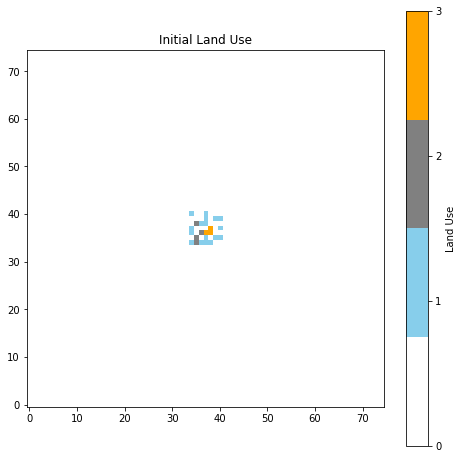

Initial counts: {0: 5601, 1: 17, 2: 4, 3: 3}
Running iteration 1...
Counts at iteration 1: {0: 5531, 1: 71, 2: 15, 3: 8}
Running iteration 2...
Counts at iteration 2: {0: 5462, 1: 124, 2: 26, 3: 13}
Running iteration 3...
Counts at iteration 3: {0: 5393, 1: 177, 2: 37, 3: 18}
Running iteration 4...
Counts at iteration 4: {0: 5324, 1: 231, 2: 47, 3: 23}
Running iteration 5...
Counts at iteration 5: {0: 5252, 1: 287, 2: 58, 3: 28}
Running iteration 6...
Counts at iteration 6: {0: 5182, 1: 342, 2: 68, 3: 33}
Running iteration 7...
Counts at iteration 7: {0: 5113, 1: 396, 2: 78, 3: 38}
Running iteration 8...
Counts at iteration 8: {0: 5043, 1: 450, 2: 89, 3: 43}
Running iteration 9...
Counts at iteration 9: {0: 4974, 1: 504, 2: 99, 3: 48}
Running iteration 10...
Counts at iteration 10: {0: 4907, 1: 555, 2: 110, 3: 53}
Running iteration 11...
Counts at iteration 11: {0: 4842, 1: 604, 2: 121, 3: 58}
Running iteration 12...


In [18]:
def run_simulation(grid, weights_table, alpha, growth_rates, radius, seed, num_iterations):
    np.random.seed(seed)
    grid_size = grid.shape[0]
    

    counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for i in range(grid_size):
        for j in range(grid_size):
            counts[grid[i, j]] += 1

    print(f"Initial counts: {counts}")

    for iteration in range(num_iterations):
        print(f"Running iteration {iteration+1}...")
        transition_potentials = calculate_transition_potentials(grid, alpha, weights_table, radius)

        highest_potentials = {}
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == states['V']:
                    potential_states = ['H', 'I', 'C']
                elif grid[i, j] == states['H']:
                    potential_states = ['I', 'C']
                elif grid[i, j] == states['I']:
                    potential_states = ['C']
                else:
                    potential_states = []
                    
                if potential_states:
                    highest_potentials[(i, j)] = max(potential_states, key=lambda state: transition_potentials[i, j, states[state]])

        for new_state_key in sorted(states, key=lambda k: states[k], reverse=True):
            new_state = states[new_state_key]
            if new_state_key != 'V':
                num_to_convert = int(grid_size * grid_size * growth_rates[new_state_key])
                potential_cells = [(i, j) for i, j in highest_potentials.keys() if highest_potentials[(i, j)] == new_state_key]
                potential_cells.sort(key=lambda cell: transition_potentials[cell[0], cell[1], states[highest_potentials[cell]]], reverse=True)
                
                for cell in potential_cells[:num_to_convert]:
                    counts[grid[cell]] -= 1
                    counts[new_state] += 1
                    grid[cell] = new_state

        print(f"Counts at iteration {iteration+1}: {counts}")

    plt.figure(figsize=(10, 10))
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
    plt.title('Final Land Use')
    plt.show()


growth_rates = {
    'H': 0.01,  
    'I': 0.002,
    'C': 0.001,
}


num_iterations = 50
# Run the simulation
grid = initial_land_use(seed_number=0, grid_size=75, plot=True)
run_simulation(grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius = 6, seed=45, num_iterations=num_iterations)


In [ ]:
def run_simulation_multiple(grid, weights_table, alpha, growth_rates, radius, seed, num_iterations):
    np.random.seed(seed)
    
    grid_size = grid.shape[0]



    for iteration in range(num_iterations):
        print(f"Running iteration {iteration+1}...")
        transition_potentials = calculate_transition_potentials(grid, alpha, weights_table, radius)

        highest_potentials = {}
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == states['V']:
                    potential_states = ['H', 'I', 'C']
                elif grid[i, j] == states['H']:
                    potential_states = ['I', 'C']
                elif grid[i, j] == states['I']:
                    potential_states = ['C']
                else:
                    potential_states = []
                    
                if potential_states:
                    highest_potentials[(i, j)] = max(potential_states, key=lambda state: transition_potentials[i, j, states[state]])

        for new_state_key in sorted(states, key=lambda k: states[k], reverse=True):
            new_state = states[new_state_key]
            if new_state_key != 'V':
                num_to_convert = int(grid_size * grid_size * growth_rates[new_state_key])
                potential_cells = [(i, j) for i, j in highest_potentials.keys() if highest_potentials[(i, j)] == new_state_key]
                potential_cells.sort(key=lambda cell: transition_potentials[cell[0], cell[1], states[highest_potentials[cell]]], reverse=True)
                
                for cell in potential_cells[:num_to_convert]:
                    
                    grid[cell] = new_state

        

    plt.figure(figsize=(10, 10))
    cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
    plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
    plt.title('Final Land Use')
    plt.show()

# make seed to be 10 random integers from 0 to 100000
seeds = np.random.randint(0, 100000, 10)

growth_rates = {
    'H': 0.007,  
    'I': 0.002,
    'C': 0.0005,
}
num_iterations = 50

for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    new_grid = initial_land_use(seed_number=seed, grid_size=grid_size, plot=True)
    run_simulation_multiple(new_grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius=6, seed=seed, num_iterations=num_iterations)
    print("Simulation completed.\n")



In [9]:
def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
        print(cluster_ids)
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters




In [17]:
def run_simulation_with_clustering(seed, grid_size, alpha, growth_rates, radius, num_iterations):
    # Run the simulation
    grid = initial_land_use(seed_number=seed, grid_size=grid_size, plot=False)
    run_simulation(grid, weights_table, alpha=alpha, growth_rates=growth_rates, radius=radius, seed=seed, num_iterations=num_iterations)

    # Compute cluster sizes
    clusters = run_clustering(grid)
    clusters['growth_rate_H'] = growth_rates['H']
    clusters['growth_rate_I'] = growth_rates['I']
    clusters['growth_rate_C'] = growth_rates['C']
    clusters['seed'] = seed
    clusters['alpha'] = alpha
    return clusters


def run_multiple_simulations(params):
    all_clusters = pd.DataFrame()
    for growth_rate_H in params['growth_rate_values_H']:
        for growth_rate_I in params['growth_rate_values_I']:
            for growth_rate_C in params['growth_rate_values_C']:
                for alpha in params['alpha_values']:
                    growth_rates = {'H': growth_rate_H, 'I': growth_rate_I, 'C': growth_rate_C}
                    clusters = run_simulation_with_clustering(params['seed'], params['grid_size'], alpha, growth_rates, params['radius'], params['num_iterations'])
                    all_clusters = pd.concat([all_clusters, clusters])
    if params['export_csv']:
        all_clusters.to_csv('cluster_data.csv', index=False)
    if params['plot']:
        for land_use_type in all_clusters['cell_type'].unique():
            cluster_sizes = all_clusters[all_clusters['cell_type'] == land_use_type]['Cluster_size']
            cluster_counts = all_clusters[all_clusters['cell_type'] == land_use_type]['Cluster_count']
            plt.scatter(cluster_sizes, cluster_counts)
            plt.yscale('log')
            plt.xscale('log')
            plt.title(f'Cluster Sizes for Land Use Type {land_use_type}')
            plt.xlabel('Cluster Size')
            plt.ylabel('Frequency')
            plt.show()
    return all_clusters




params = {
    'growth_rate_values_H': [0.01],
    'growth_rate_values_I': [0.003],
    'growth_rate_values_C': [0.0007],
    'alpha_values': [2.0, 2.2],
    'seed': 4, # change this number, for whatever you like (@ v @ ~). 
    'grid_size': 100,
    'radius': 6,
    'num_iterations': 50,
    'export_csv': True,
    'plot': False
}



Initial counts: {0: 9974, 1: 19, 2: 4, 3: 3}
Running iteration 1...
Counts at iteration 1: {0: 9838, 1: 115, 2: 34, 3: 13}
Running iteration 2...
Counts at iteration 2: {0: 9708, 1: 206, 2: 63, 3: 23}
Running iteration 3...
Counts at iteration 3: {0: 9573, 1: 301, 2: 93, 3: 33}
Running iteration 4...
Counts at iteration 4: {0: 9442, 1: 392, 2: 123, 3: 43}
Running iteration 5...
Counts at iteration 5: {0: 9310, 1: 485, 2: 152, 3: 53}
Running iteration 6...
Counts at iteration 6: {0: 9176, 1: 579, 2: 182, 3: 63}
Running iteration 7...
Counts at iteration 7: {0: 9044, 1: 671, 2: 212, 3: 73}
Running iteration 8...
Counts at iteration 8: {0: 8913, 1: 762, 2: 242, 3: 83}
Running iteration 9...
Counts at iteration 9: {0: 8779, 1: 856, 2: 272, 3: 93}
Running iteration 10...
Counts at iteration 10: {0: 8644, 1: 951, 2: 302, 3: 103}
Running iteration 11...
Counts at iteration 11: {0: 8514, 1: 1042, 2: 331, 3: 113}
Running iteration 12...
Counts at iteration 12: {0: 8382, 1: 1135, 2: 360, 3: 123}

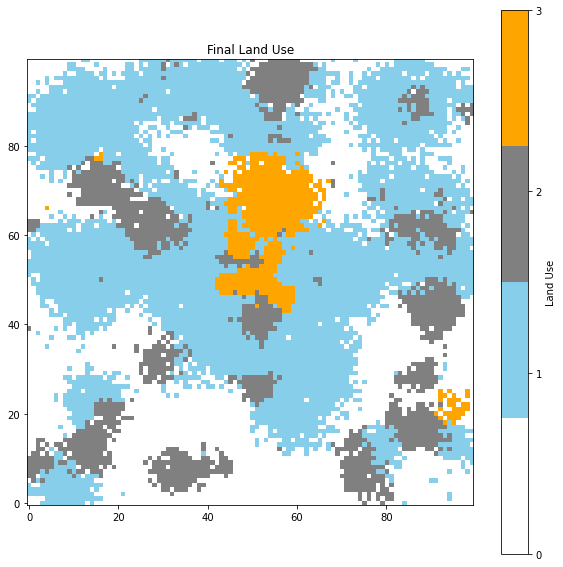

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  1.   1.   1. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 337. 337.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Initial counts: {0: 9974, 1: 19, 2: 4, 3: 3}
Running iteration 1...
Counts at iteration 1: {0: 9836, 1: 117, 2: 34, 3: 13}
Running iteration 2...
Counts at iteration 2: {0: 9701, 1: 212, 2: 64, 3: 23}
Running iteration 3...
Counts at iteration 3: {0: 9571, 1: 302, 2: 94, 3: 33}
Running iteration 4...
Counts at iteration 4: {0: 9435, 1: 399, 2: 123, 3: 43}
Running iteration 5...
Counts at iteration 5: {0: 9305, 1: 490, 2: 152, 3: 53}
Running iteration 6...


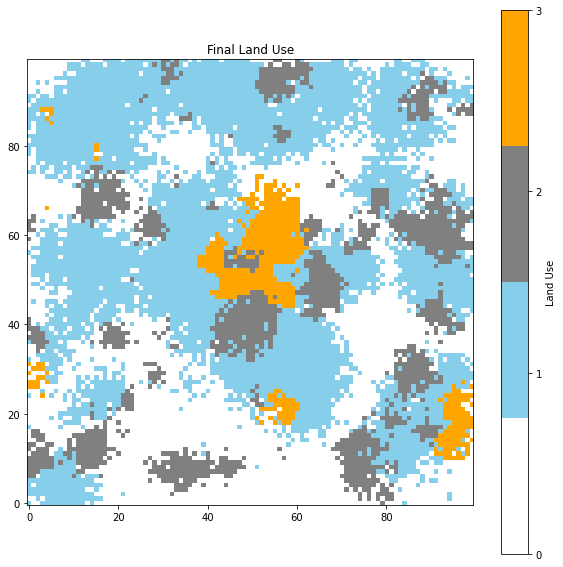

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]
 [2. 2. 2. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:

all_clusters = run_multiple_simulations(params)